In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True)
data = cifar_trainset.data / 255 # data is numpy array

mean = data.mean(axis = (0,1,2))
std = data.std(axis = (0,1,2))
print(f"Mean : {mean}   STD: {std}")

100%|██████████| 170498071/170498071 [00:13<00:00, 12886337.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Mean : [0.49139968 0.48215841 0.44653091]   STD: [0.24703223 0.24348513 0.26158784]


In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))])

test_transforms = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))])

In [ ]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
batch_size = 128
shuffle = True

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=shuffle, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=shuffle, pin_memory=True)

In [ ]:
images, labels = next(iter(train_dataloader))

In [ ]:
images.shape

torch.Size([128, 3, 32, 32])

In [ ]:
labels[0]

tensor(0)

In [ ]:
cifar_trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Text(0.5, 1.0, 'airplane')

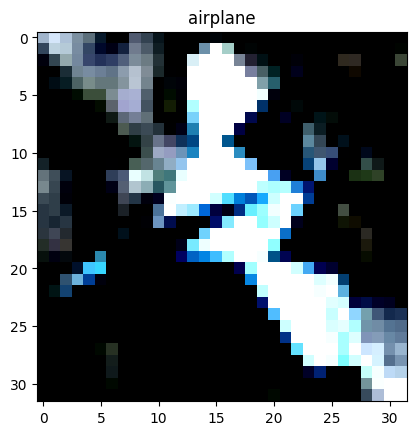

In [ ]:
plt.imshow(images[0].permute(1, 2, 0))
plt.title(cifar_trainset.classes[labels[0].item()])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, bias=False), # 32 > 32 | 1 > 3
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False), # 32 > 32 | 3 > 5
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        # Transition Layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, bias=False), # 32 > 32 | 5 > 5
            nn.MaxPool2d(kernel_size=2) # 32 > 16 | 5 > 6
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 16 > 16 | 6 > 10
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 16 > 16 | 10 > 14
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False), # 16 > 16 | 14 > 18
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        # Transition Layer
        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, bias=False), # 16 > 16 | 18 > 18
            nn.MaxPool2d(kernel_size=2) # 16 > 8 | 18 > 20
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 8 > 8 | 20 > 28
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, bias=False), # 8 > 8 | 28 > 36
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )
        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, bias=False), # 8 > 8 | 36 > 44
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )

        self.gap = nn.AdaptiveAvgPool2d(output_size=1) # 8 >> 1 || GAP
        self.conv11 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=1, bias=False) # 1 > 1


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.gap(x)
        x = self.conv11(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=1)


In [ ]:
model = Model().to(device)
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 32, 32, 32]           4,608
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 16, 32, 32]             512
         MaxPool2d-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]           2,304
             ReLU-10           [-1, 16, 16, 16]               0
      BatchNorm2d-11           [-1, 16, 16, 16]              32
           Conv2d-12           [-1, 16, 16, 16]           2,304
             ReLU-13           [-1, 16, 16, 16]               0
      BatchNorm2d-14           [-1, 16,

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.05)

for epoch in range(20):
    print("epoch: ", epoch)
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
    scheduler.step()

epoch:  0


Loss=1.3717082738876343 Batch_id=390 Accuracy=44.41: 100%|██████████| 391/391 [00:19<00:00, 19.92it/s]



Test set: Average loss: 1.3101, Accuracy: 5302/10000 (53.02%)

epoch:  1


Loss=0.842985987663269 Batch_id=390 Accuracy=59.47: 100%|██████████| 391/391 [00:19<00:00, 20.18it/s]



Test set: Average loss: 1.0391, Accuracy: 6271/10000 (62.71%)

epoch:  2


Loss=1.0752856731414795 Batch_id=390 Accuracy=64.82: 100%|██████████| 391/391 [00:19<00:00, 20.12it/s]



Test set: Average loss: 0.9432, Accuracy: 6624/10000 (66.24%)

epoch:  3


Loss=0.809678852558136 Batch_id=390 Accuracy=67.98: 100%|██████████| 391/391 [00:19<00:00, 20.42it/s]



Test set: Average loss: 0.9396, Accuracy: 6675/10000 (66.75%)

epoch:  4


Loss=0.9965472221374512 Batch_id=390 Accuracy=72.60: 100%|██████████| 391/391 [00:19<00:00, 20.49it/s]



Test set: Average loss: 0.8103, Accuracy: 7100/10000 (71.00%)

epoch:  5


Loss=0.8263763189315796 Batch_id=390 Accuracy=73.41: 100%|██████████| 391/391 [00:19<00:00, 20.56it/s]



Test set: Average loss: 0.8009, Accuracy: 7146/10000 (71.46%)

epoch:  6


Loss=0.7356027364730835 Batch_id=390 Accuracy=73.93: 100%|██████████| 391/391 [00:19<00:00, 20.02it/s]



Test set: Average loss: 0.7969, Accuracy: 7162/10000 (71.62%)

epoch:  7


Loss=0.6482812166213989 Batch_id=390 Accuracy=74.22: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]



Test set: Average loss: 0.7909, Accuracy: 7188/10000 (71.88%)

epoch:  8


Loss=0.5703673362731934 Batch_id=390 Accuracy=74.74: 100%|██████████| 391/391 [00:19<00:00, 19.91it/s]



Test set: Average loss: 0.7886, Accuracy: 7211/10000 (72.11%)

epoch:  9


Loss=0.6203294992446899 Batch_id=390 Accuracy=74.66: 100%|██████████| 391/391 [00:19<00:00, 20.48it/s]



Test set: Average loss: 0.7885, Accuracy: 7214/10000 (72.14%)

epoch:  10


Loss=0.6307549476623535 Batch_id=390 Accuracy=74.84: 100%|██████████| 391/391 [00:19<00:00, 20.48it/s]



Test set: Average loss: 0.7872, Accuracy: 7228/10000 (72.28%)

epoch:  11


Loss=0.6692244410514832 Batch_id=390 Accuracy=74.67: 100%|██████████| 391/391 [00:19<00:00, 19.99it/s]



Test set: Average loss: 0.7868, Accuracy: 7234/10000 (72.34%)

epoch:  12


Loss=0.5655564069747925 Batch_id=390 Accuracy=74.84: 100%|██████████| 391/391 [00:19<00:00, 19.72it/s]



Test set: Average loss: 0.7870, Accuracy: 7224/10000 (72.24%)

epoch:  13


Loss=0.7993333339691162 Batch_id=390 Accuracy=74.86: 100%|██████████| 391/391 [00:19<00:00, 20.06it/s]



Test set: Average loss: 0.7873, Accuracy: 7249/10000 (72.49%)

epoch:  14


Loss=0.7072831392288208 Batch_id=390 Accuracy=74.72: 100%|██████████| 391/391 [00:19<00:00, 19.96it/s]



Test set: Average loss: 0.7880, Accuracy: 7212/10000 (72.12%)

epoch:  15


Loss=0.722248375415802 Batch_id=390 Accuracy=74.63: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.7874, Accuracy: 7214/10000 (72.14%)

epoch:  16


Loss=0.9148752093315125 Batch_id=390 Accuracy=74.72: 100%|██████████| 391/391 [00:18<00:00, 20.70it/s]



Test set: Average loss: 0.7881, Accuracy: 7216/10000 (72.16%)

epoch:  17


Loss=0.6168214082717896 Batch_id=390 Accuracy=74.88: 100%|██████████| 391/391 [00:19<00:00, 20.18it/s]



Test set: Average loss: 0.7885, Accuracy: 7229/10000 (72.29%)

epoch:  18


Loss=0.6350690126419067 Batch_id=390 Accuracy=74.89: 100%|██████████| 391/391 [00:19<00:00, 19.79it/s]



Test set: Average loss: 0.7873, Accuracy: 7226/10000 (72.26%)

epoch:  19


Loss=0.8528950810432434 Batch_id=390 Accuracy=74.80: 100%|██████████| 391/391 [00:19<00:00, 19.73it/s]



Test set: Average loss: 0.7894, Accuracy: 7219/10000 (72.19%)



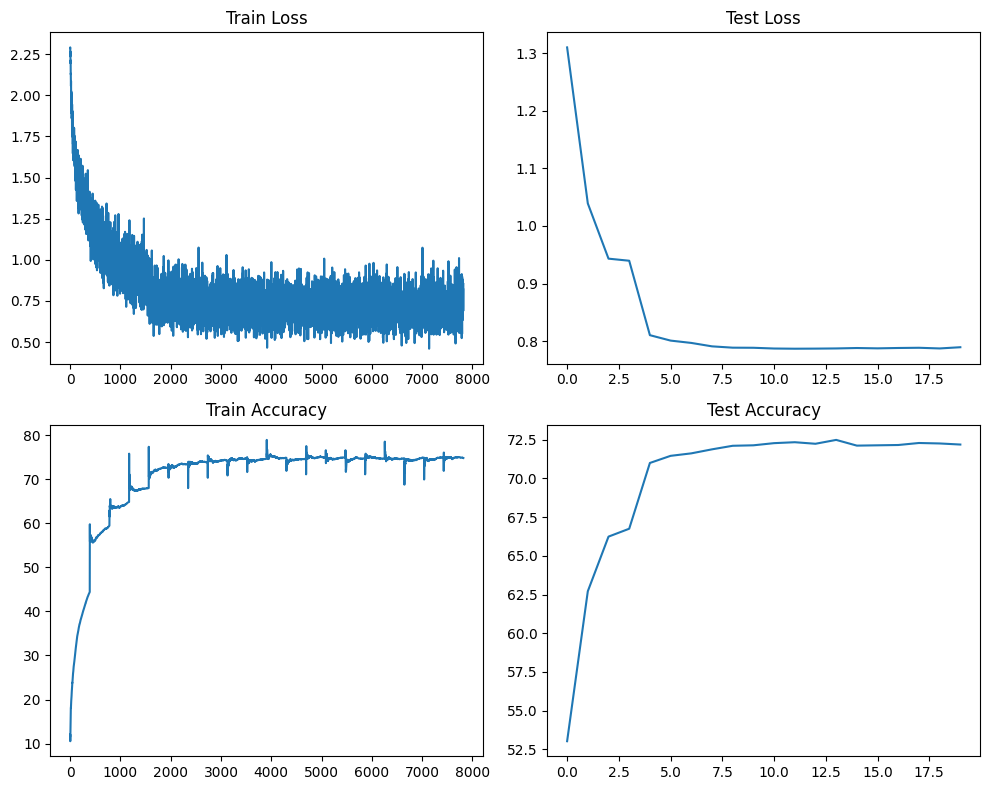

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot( [t.item() for t in train_losses])
axs[0, 0].set_title('Train Loss')
axs[0, 1].plot(test_losses)
axs[0, 1].set_title('Test Loss')
axs[1, 0].plot(train_acc)
axs[1, 0].set_title('Train Accuracy')
axs[1, 1].plot(test_acc)
axs[1, 1].set_title('Test Accuracy')

fig.tight_layout()

In [ ]:
def predict(model, device, test_loader):
    model.eval()
    wrong_labels = []
    image_list = []
    pred_list = []
    label_list = []

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            preds = output.argmax(dim=1, keepdim=True).cpu()  # get the index of the max log-probability

            wrong_indices = torch.argwhere(preds != target).flatten()
            pred_list += preds[wrong_indices].tolist()
            image_list += [img for img in images[wrong_indices].cpu()]
            label_list += labels[wrong_indices].tolist()

            if len(label_list) > 10:
                break


    pred_list = pred_list[:10]
    label_list = label_list[:10]
    image_list = image_list[:10]

    fig, axs = plt.subplots(5, 2, figsize=(16, 10))
    for i in range(5):
        for j in range(2):
            img = image_list.pop()
            img = img / 2 + 0.5     # unnormalize
            img = img.numpy()
            axs[i,j].imshow(np.transpose(img, (1, 2, 0)))

            axs[i,j].set_title(f"Label: {cifar_trainset.classes[label_list.pop()]} | Pred: {cifar_trainset.classes[pred_list.pop()[0]]}")
    fig.tight_layout()

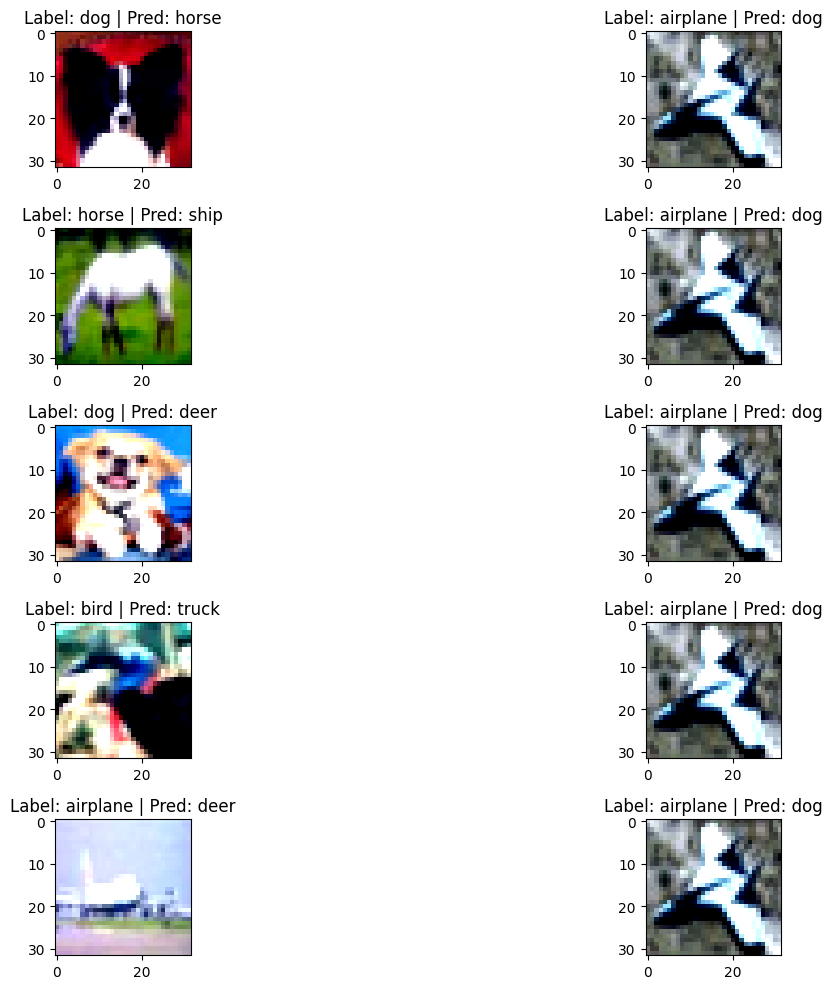

In [ ]:
predict(model, device, test_dataloader)